In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [224]:
def CameraCal(images):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((5*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,5), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,5), corners, ret)
    img_size = img.shape
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size[:2],None,None)
    return mtx, dist

In [222]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = CameraCal(images)
print(mtx) # camera matrix
print(dist) # distortaion coefficents
import pickle
%matplotlib inline
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

[[5.48015432e+03 0.00000000e+00 7.68200463e+02]
 [0.00000000e+00 5.54624831e+03 5.31607127e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-4.89236815e+00 -6.07867497e+01 -1.24313008e-01 -1.13868240e-01
   1.74639877e+03]]


## Apply a distortion correction to raw images.

Text(0.5, 1.0, 'Undistorted Image')

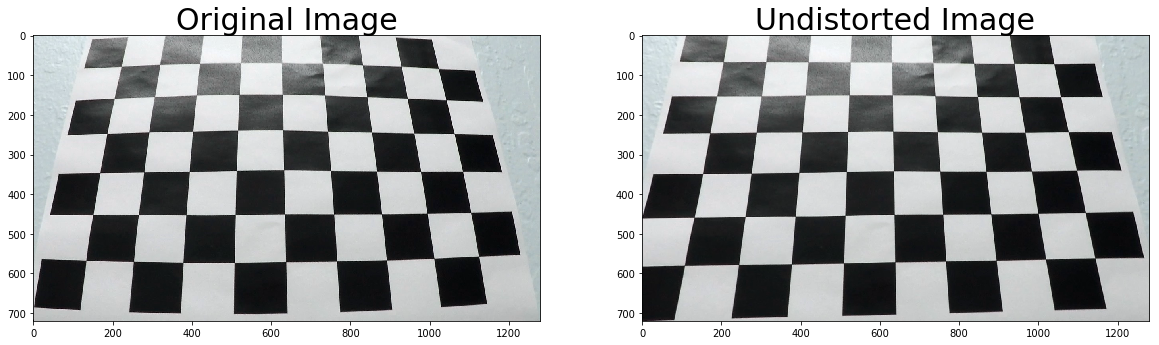

In [223]:
# Test undistortion on an image
# img = cv2.imread('test_images/test1.jpg')
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('output_images/test1_undist.jpg',dst)
# cv2.imwrite('output_images/cal3_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Use color transforms, gradients, etc., to create a thresholded binary image.

In [167]:
def color_thresh(img, s_thresh=(150, 255), l_thresh=(15, 255)):  # s_thresh=(170, 255), l_thresh=(10, 255): only 1047 & 48 won't work
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Threshold color channel
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    return color_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 250)):
    # Calculate gradient magnitude5
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2, 0+np.pi/2, np.pi)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1]) | (absgraddir >= thresh[2]) & (absgraddir <= thresh[3])] = 1
    return dir_binary

def combin_thre(ksize, undist):
# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(30, 80))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(10, 120)) 
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 250)) #(30, 250)
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/3,np.pi*2/3, np.pi*5/6)) #15, thresh=(0, np.pi/2)
    col_binary = color_thresh(undist)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary ==1) ] = 1
    
    return combined

Text(0.5, 1.0, 'Undistorted Image')

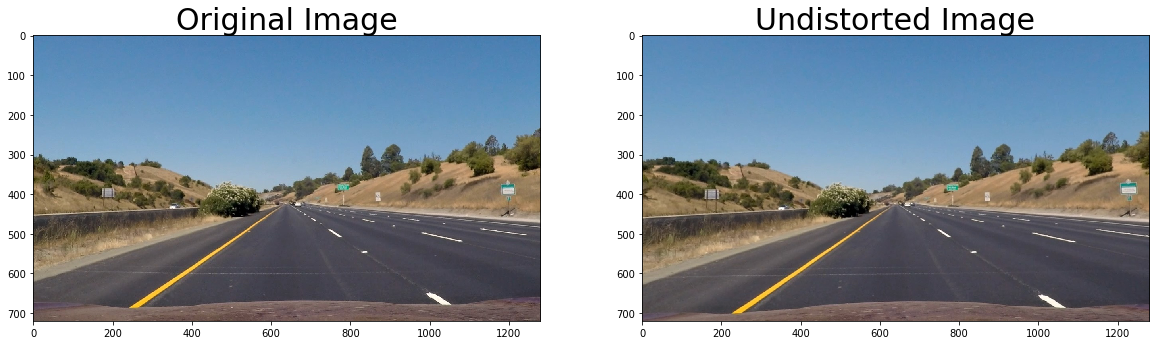

In [225]:
# check distortion
img = mpimg.imread('test_images/straight_lines1.jpg')
# img = mpimg.imread('Issue_images/frame1047.jpg') # for debugging
img_size = (img.shape[1], img.shape[0])
undist = cv2.undistort(img, mtx, dist, None, mtx)

# img
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)


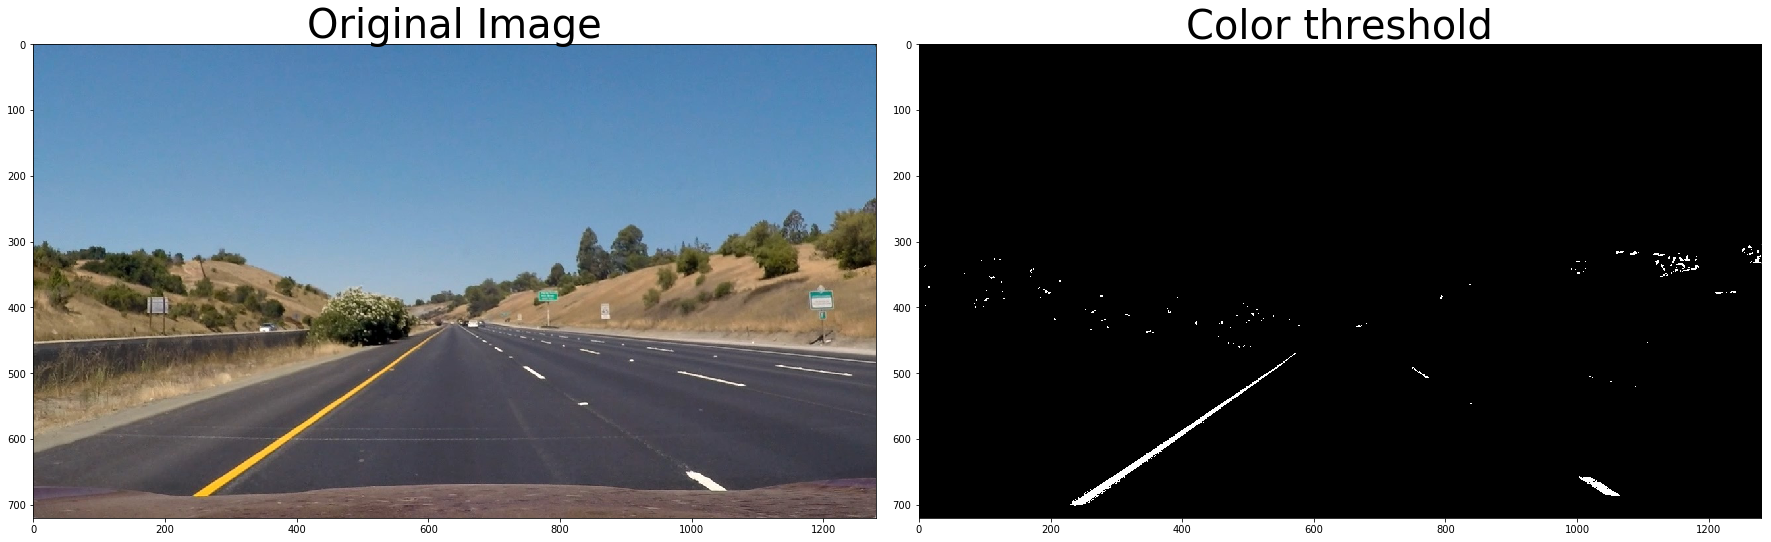

In [226]:
# check color conversion
# col_binary = color_thresh(img, s_thresh=170, l_thresh = 170)
col_binary = color_thresh(undist, s_thresh=(170, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(col_binary, cmap='gray')
ax2.set_title('Color threshold', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt_images(img, 'Source image', result, 'Color thresholded')

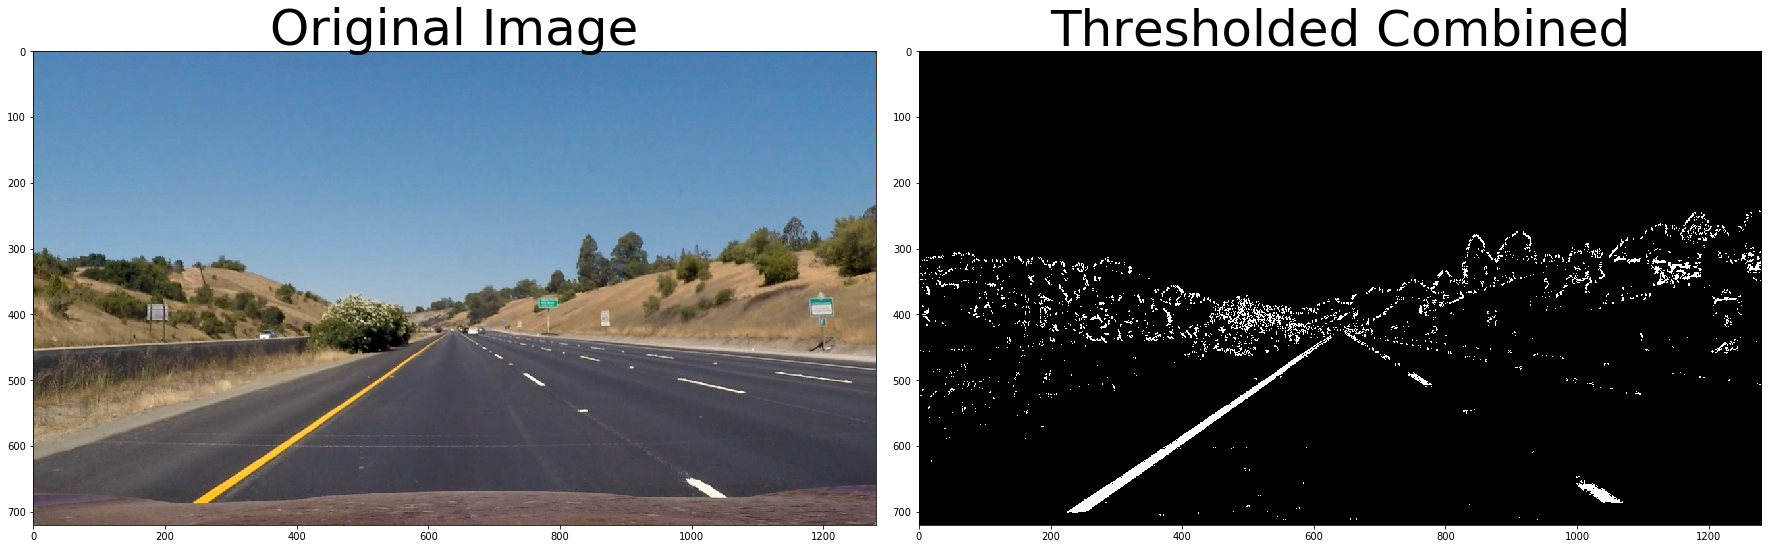

In [227]:
# Combined threshold
ksize = 3 # Choose a larger odd number to smooth gradient measurements
combined = combin_thre(ksize, undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view”).

In [228]:
def birdseye(undist,src, dst):
# Apply perspective transform. Input undistorted binary image for birdseye transform.
    img_size = (undist.shape[1], undist.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, Minv

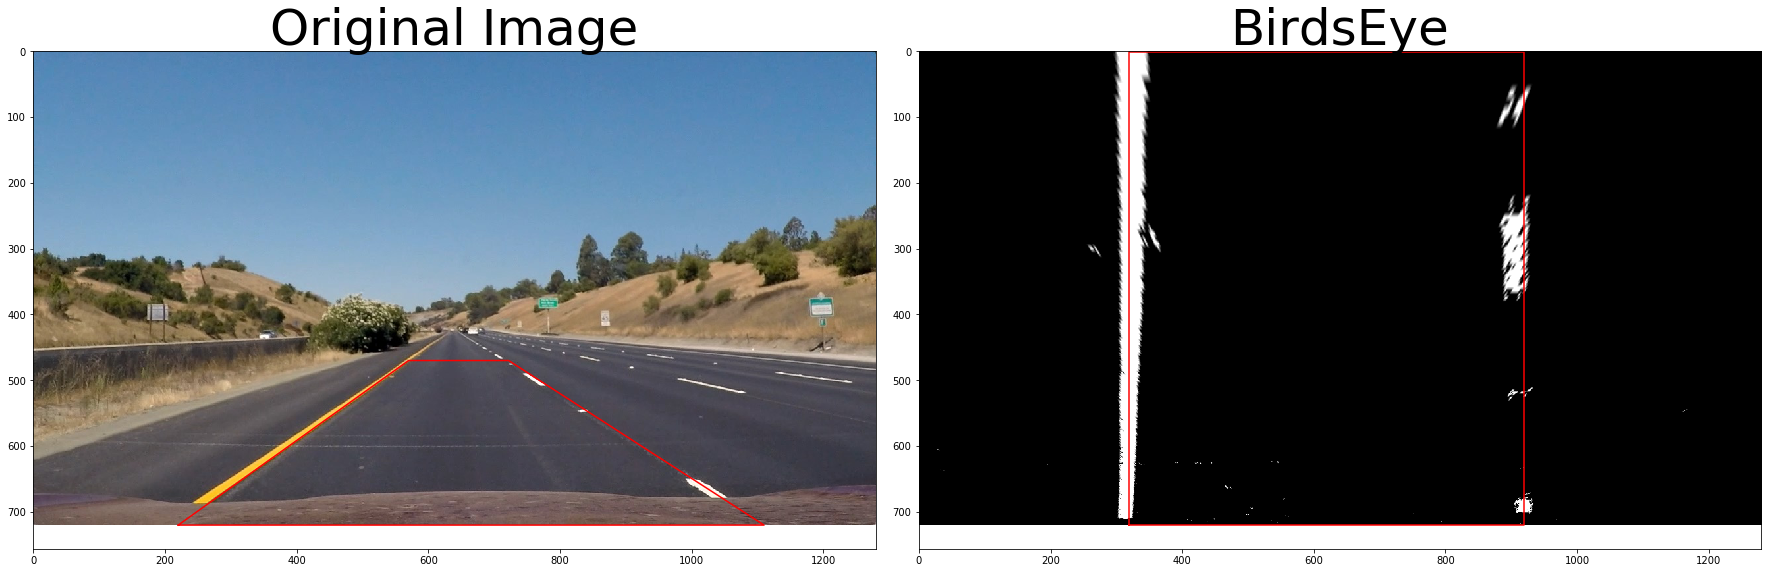

In [229]:
src = np.float32(
    [[220,  720],  # Bottom left
     [570, 470],  # Top left
     [722, 470],  # Top right
     [1110, 720]]) # Bottom right

dst = np.float32(
    [[320,720],  # Bottom left
     [320, 1],  # Top left
     [920, 1],  # Top right
     [920, 720]]) # Bottom right 

warp, Minv = birdseye(combined,src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax2.imshow(warp, cmap='gray')
ax2.set_title('BirdsEye', fontsize=50)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [230]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//3:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

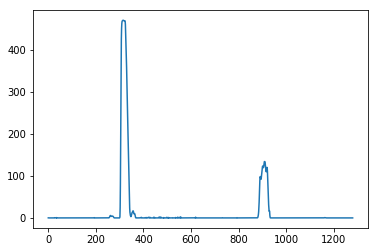

In [231]:
histogram = hist(warp)
plt.plot(histogram)

In [254]:
def find_lane_line(binary_warped, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = (out_img*255).astype('uint8')
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//3)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    
    nwindows = 10 # Choose the number of sliding windows, 10 for project
    margin = 70 # Set the width of the windows +/- margin, 70 for project
    minpix = 50 # Set minimum number of pixels found to recenter window    
    window_height = np.int(binary_warped.shape[0]//nwindows) # Set height of windows - based on nwindows above and image shape

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    
    for window in range(nwindows): # Step through the windows one by one
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        #Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
      

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    if return_img:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
 
    
    return out_img, ploty, left_fit, right_fit, leftx, rightx 
    # leftx and rightx is the predition from polynominal fit points
    # left_fit and right_fit is the coeff 


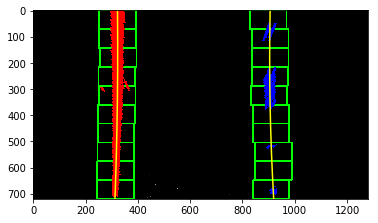

In [233]:
out_img, ploty, left_fit, right_fit, leftx, rightx = find_lane_line(warp, return_img=True)

plt.imshow(out_img)


In [258]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit_coeff = np.polyfit(lefty, leftx, 2)
    right_fit_coeff = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit_coeff[0]*ploty**2 + left_fit_coeff[1]*ploty + left_fit_coeff[2]
    right_fitx = right_fit_coeff[0]*ploty**2 + right_fit_coeff[1]*ploty + right_fit_coeff[2]
    return ploty, left_fit_coeff, right_fit_coeff, left_fitx, right_fitx

def search_around_poly(binary_warped, left_fit, right_fit, return_img=False):
    
    margin = 70 

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > 
                       (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)
                      ) & (nonzerox < 
                           (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    ploty,left_fit_coeff, right_fit_coeff, left_fitx, right_fitx = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if return_img:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color = 'yellow')
        plt.plot(right_fitx, ploty, color = 'yellow')
        ## End visualization steps ##
    
    return result, ploty, left_fit_coeff, right_fit_coeff, left_fitx, right_fitx


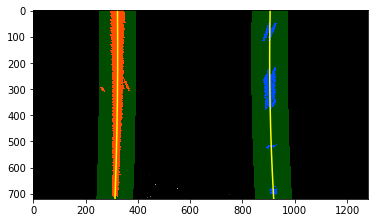

In [239]:
result2, ploty, left_fit_coeff, right_fit_coeff, left_fitx, right_fitx = search_around_poly(warp, left_fit, right_fit, return_img=True)

# View your output
plt.imshow(result2)

## Determine the curvature of the lane and vehicle position with respect to center.

In [240]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature from the bottom of the image
    y_eval = np.max(ploty)
    
    #Implement the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def car_offset(leftx, rightx, xm_per_pix, ym_per_pix, img_size):
    lane_center = (np.mean(leftx) + np.mean(rightx))/2
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    
    return center_offset_mtrs


In [241]:
xm_per_pix = 3.7/700 # meters per pixel in x dimension
ym_per_pix = 30/720 # meters per pixel in y dimension

# compute the curvature of left line and right line
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_coeff, right_fit_coeff, xm_per_pix, ym_per_pix)
curvature = (left_curverad + right_curverad)*0.5
print('Rihgt line curvature =', left_curverad, 'm; Left line curvature =', right_curverad, 'm')
curvature_string = "Average curvature = %.2f m" % curvature
print(curvature_string)

# compute the offset from the center
center_offset_mtrs = car_offset(left_fitx, right_fitx, xm_per_pix, ym_per_pix, img_size)   
offset_string = "Center offset = %.2f m" % center_offset_mtrs
print(offset_string)

Rihgt line curvature = 15323.649317007306 m; Left line curvature = 9333.874549255905 m
Average curvature = 12328.76 m
Center offset = 0.14 m


## Warp the detected lane boundaries back onto the original image.

In [242]:
def lane_shade(img, warp, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    shade = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(shade, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(shade, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    test = cv2.addWeighted(img, 1, unwarp, 0.3, 0)  
    
    return test


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

(-0.5, 1279.5, 719.5, -0.5)

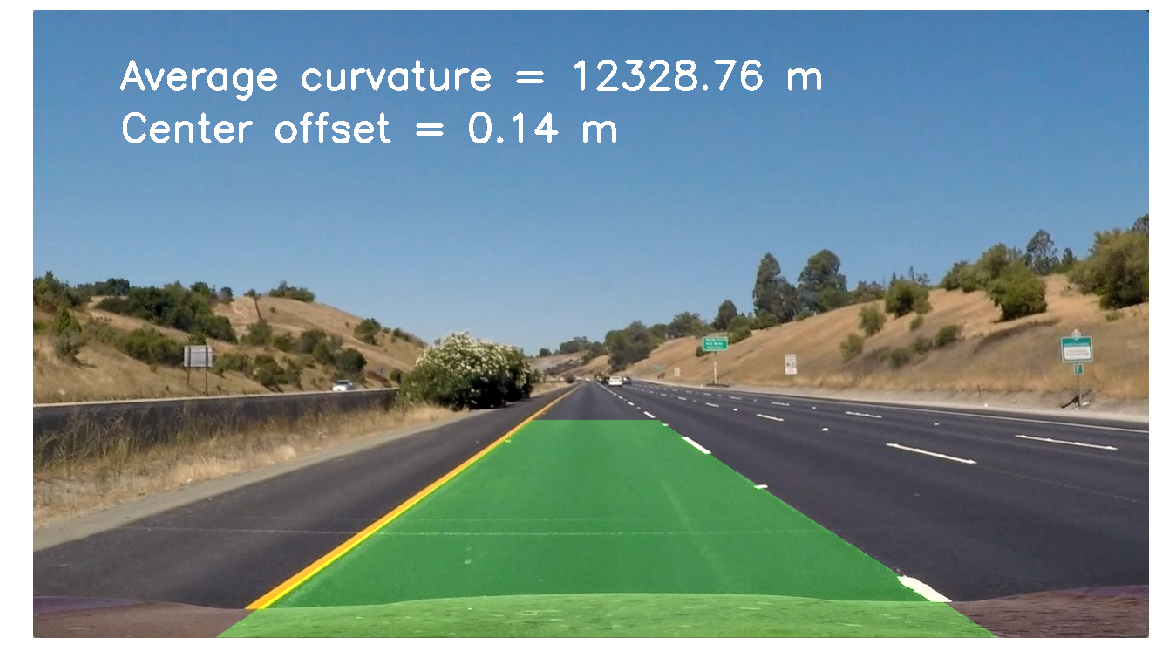

In [248]:
test = lane_shade(img, warp, ploty, left_fitx, right_fitx, Minv)
cv2.putText(test,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=4)
cv2.putText(test, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=4)
plt.figure(figsize=(20,20))
test2 = plt.imshow(test)
plt.axis('off')


# Final Pipeline

In [249]:
isinit = False
left_fit0 = [] 
right_fit0 = []

def findlane(img):
    global isinit
    global left_fit0
    global right_fit0
    
    # Undstort the image
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Create binary image with thresholds in color and sobel, a guassian filter of 3 is used. 
    combined = combin_thre(3, undist)
    
    # Warp the image to birds-eye view, hard-code the perpective tranformation matrix src/dst coordinates.
    src = np.float32(
        [[220,  720],  # Bottom left
         [570, 470],  # Top left
         [722, 470],  # Top right
         [1110, 720]]) # Bottom right

    dst = np.float32(
        [[320,720],  # Bottom left
         [320, 1],  # Top left
         [920, 1],  # Top right
         [920, 720]]) # Bottom right #
    warp, Minv = birdseye(combined,src, dst)

    # Find lane line: 1st iteration start from sliding window search, 
    # the later frames will use the previous frame polynomial fit coefficents as input
    if isinit == False:
        out_img0, ploty0,left_fit0, right_fit0, leftx, rightx = find_lane_line(warp, return_img=False)
        isinit = True
    out_img1, ploty,left_fit_coeff, right_fit_coeff, left_fitx, right_fitx = search_around_poly(warp, left_fit0, right_fit0, return_img=False)
    left_fit0 = left_fit_coeff 
    right_fit0 = right_fit_coeff
    
    # Convert pixel to real dimension
    xm_per_pix = 3.7/700 
    ym_per_pix = 30/720 

    # Compute the curvature of left line and right line
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_coeff, right_fit_coeff, xm_per_pix, ym_per_pix)
    curvature = (left_curverad + right_curverad)*0.5
    curvature_string = "Average curvature = %.2f m" % curvature

    # Compute the offset from the center
    center_offset_mtrs = car_offset(left_fitx, right_fitx, xm_per_pix, ym_per_pix, img_size)   
    offset_string = "Center offset = %.2f m" % center_offset_mtrs

    # Overlay a green shade between lane lines
    test = lane_shade(img, warp, ploty, left_fitx, right_fitx, Minv)
    cv2.putText(test,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=4)
    cv2.putText(test, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=4)
    
    return test
    

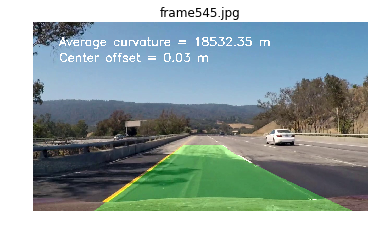

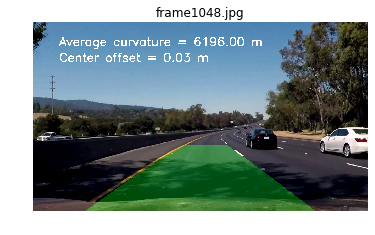

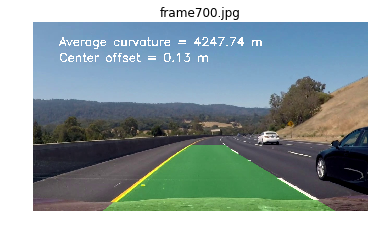

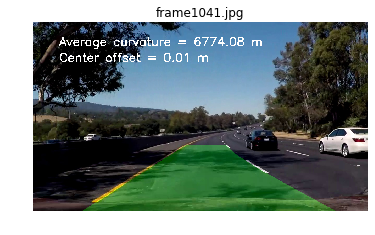

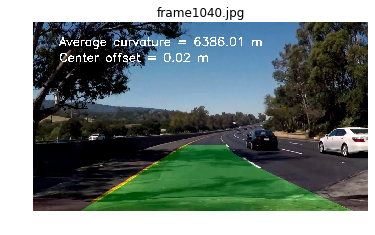

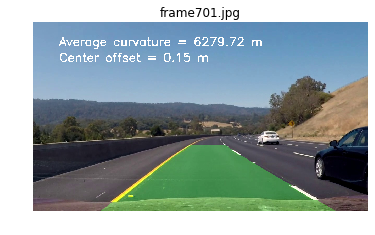

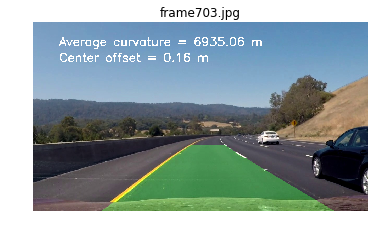

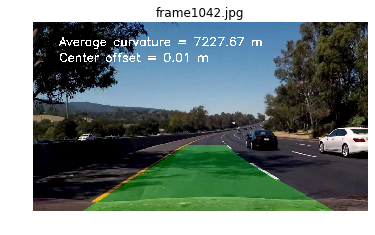

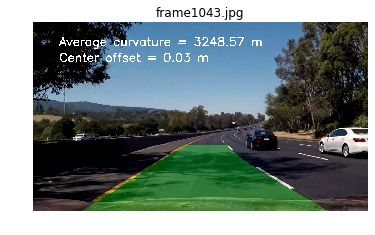

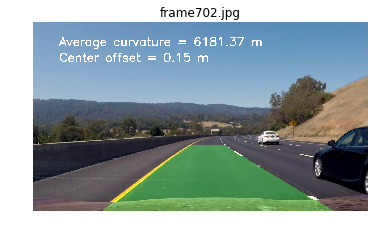

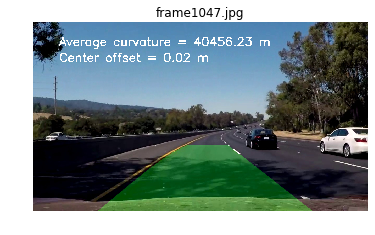

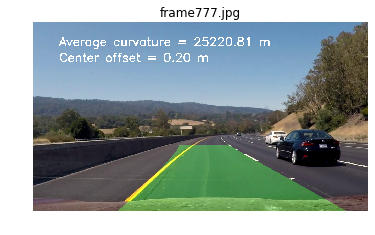

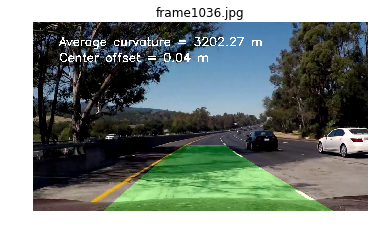

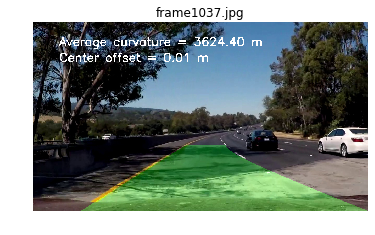

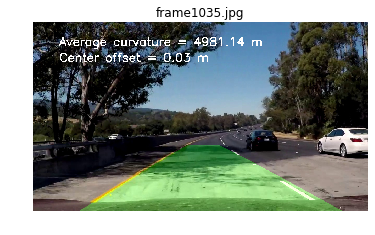

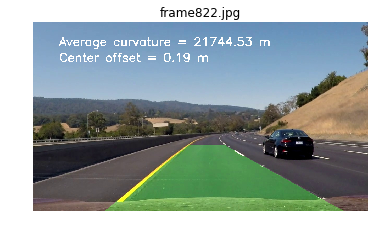

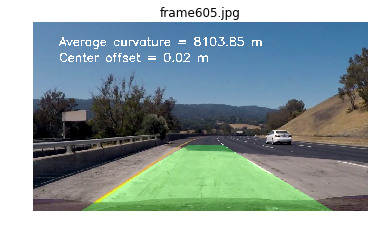

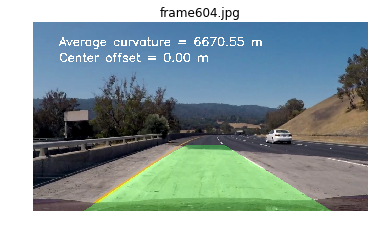

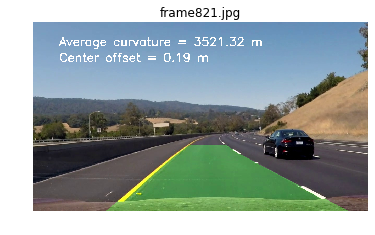

In [251]:
import os
PATH = "Issue_images/"
test_images = os.listdir(PATH)

for img in test_images:
    plt.figure(); plt.title(img); plt.axis('off')
    img = mpimg.imread(PATH + img)
    test = findlane(img)
    test2 = plt.imshow(test)

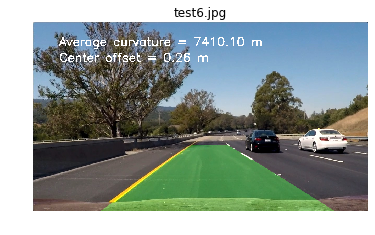

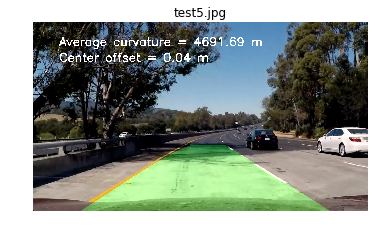

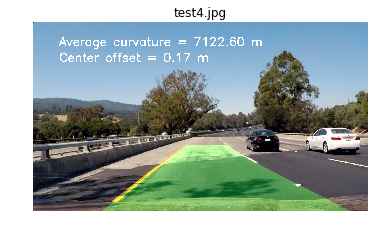

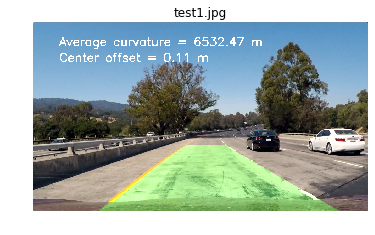

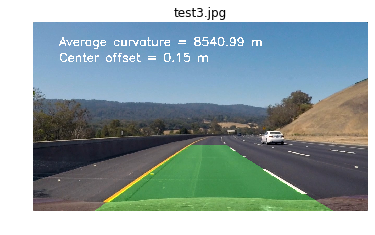

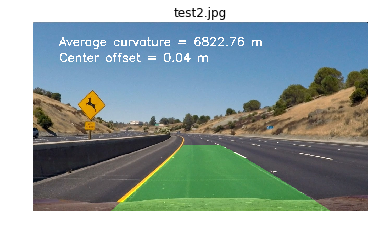

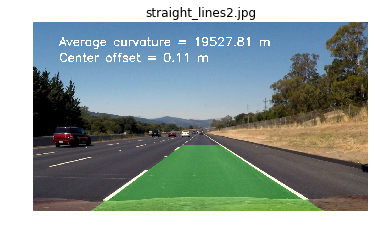

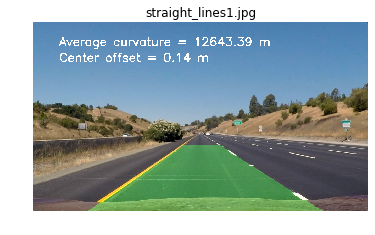

In [250]:
import os
PATH = "test_images/"
test_images = os.listdir(PATH)

for img in test_images:
    plt.figure(); plt.title(img); plt.axis('off')
    img = mpimg.imread(PATH + img)
    test = findlane(img)
    test2 = plt.imshow(test)

In [155]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [217]:
output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(26,35)
test_clip = clip1.fl_image(findlane) #NOTE: this function expects color images!!
%time test_clip.write_videofile(output, audio=False)

t:   0%|          | 2/1260 [00:00<01:53, 11.10it/s, now=None]

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4
CPU times: user 14min 4s, sys: 1min 15s, total: 15min 19s
Wall time: 3min 46s


In [260]:
output = 'harder_challenge_video_ouput.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(1,5)
test_clip = clip1.fl_image(findlane) #NOTE: this function expects color images!!
%time test_clip.write_videofile(output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_ouput.mp4.
Moviepy - Writing video harder_challenge_video_ouput.mp4



Moviepy - Done !
Moviepy - video ready harder_challenge_video_ouput.mp4
CPU times: user 14min 29s, sys: 1min 15s, total: 15min 45s
Wall time: 3min 56s
